In [ ]:
from collections import deque
from gym import spaces
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pygame
import random
import threading
import time
import torch
import torch.nn as nn
import torch.optim as optim

In [1]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))  # Convert states to numpy arrays for storage

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        
        return torch.FloatTensor(state), torch.LongTensor(action), torch.FloatTensor(reward), torch.FloatTensor(next_state), torch.FloatTensor(done)

class PongEnvironment(gym.Env):
    def __init__(self):
        super(PongEnvironment, self).__init__()
        self.width = 400
        self.height = 300
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array([self.width // 2, random.randint(0,self.height) // 2], dtype=float)
        self.ball_vel = np.array([5, 1], dtype=float) * 100
        self.paddle_pos = self.height // 2
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def reset(self):
        self.time_step=0
        self.start_time=time.time()
        self.tot_reward=0
        self.ball_pos = np.array([self.width // 2, self.height // random.randrange(1,10)], dtype=float)
        self.ball_vel = np.array([random.random(), random.random()], dtype=float) * 100
        self.paddle_pos = self.height // 2
        return self.get_state()

    def step(self, action):
        
        self.time_step+=1
        if action == 0:
            move = -5
        else:
            move = 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel

        if (
            self.ball_pos[1] <= self.ball_radius
            or self.ball_pos[1] >= self.height - self.ball_radius
        ):
            self.ball_vel[1] *= -1

        reward = 0
        done = False

        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if (
                self.paddle_pos - self.paddle_height / 2
                <= self.ball_pos[1]
                <= self.paddle_pos + self.paddle_height / 2
            ):
                self.ball_vel[0] *= -1
                reward = 1
                self.tot_reward+=1
            else:
                reward = 0
                done = True
        if self.tot_reward>10 or time.time()-self.start_time>30:
            if self.tot_reward>10:
                print('xxx')
            done = True
        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return self.get_state(), reward, done, {}

    def move_paddle(self, move):
        self.paddle_pos = np.clip(
            self.paddle_pos + move,
            self.paddle_height / 2,
            self.height - self.paddle_height / 2,
        )

    def get_state(self):
        return np.array(
            [
                self.ball_pos[0] / self.width,
                self.ball_pos[1] / self.height,
                self.ball_vel[0] / 100,
                self.ball_vel[1] / 100,
                self.paddle_pos / self.height,
            ]
        )

    def render(self, mode="rgb_array"):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(
            self.screen,
            (255, 255, 255),
            pygame.Rect(
                0,
                int(self.paddle_pos - self.paddle_height / 2),
                self.paddle_width,
                self.paddle_height,
            ),
        )
        pygame.draw.circle(
            self.screen,
            (255, 255, 255),
            (int(self.ball_pos[0]), int(self.ball_pos[1])),
            self.ball_radius,
        )
        pygame.display.update()

        if mode == "rgb_array":
            data = pygame.surfarray.array3d(pygame.display.get_surface())
            return np.transpose(data, (1, 0, 2))
        return np.transpose(data, (1, 0, 2))


class DQNAgent:
    def __init__(self, env):
        self.model = DQN("MlpPolicy", env, verbose=1)
        self.env=env

    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done and episode_reward<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward
            total_rewards += episode_reward
            # print(episode_reward)
            total_rewards_list.append(episode_reward)
            
        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


class PPOAgent:
    def __init__(self, env):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.env=env


    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done and total_rewards<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward

            total_rewards += episode_reward
            # print(episode_reward)
            total_rewards_list.append(episode_reward)
            print(zz)
            
        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


class A2CAgent:
    def __init__(self, env):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.env=env

    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
        
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done and episode_reward<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward

            total_rewards += episode_reward
            print(episode_reward)
            total_rewards_list.append(episode_reward)
            print(zz)
            
        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


env = DummyVecEnv([lambda: PongEnvironment()])

dqn_agent = DQNAgent(env)
ppo_agent = PPOAgent(env)
a2c_agent = A2CAgent(env)


total_timesteps = 100000
# dqn_agent.train(total_timesteps)
# ppo_agent.train(total_timesteps)
# a2c_agent.train(total_timesteps)


dqn_agent.model = DQN.load('./dqn.zip')
ppo_agent.model = PPO.load('./ppo.zip')
a2c_agent.model = A2C.load('./a2c.zip')



expert_agents=[dqn_agent,ppo_agent,a2c_agent]
expert_agents_2=[ppo_agent,dqn_agent]


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Using cpu device
Using cpu device


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


Episode 0, Total Reward: 0, Average Loss: 0.016574423760175705
Episode 1, Total Reward: 0, Average Loss: 0.012563345022499561
Episode 2, Total Reward: 0, Average Loss: 0.009458175860345364
Episode 3, Total Reward: 0, Average Loss: 0.008630246855318546
Episode 4, Total Reward: 0, Average Loss: 0.007301445584744215
Episode 5, Total Reward: 0, Average Loss: 0.010480358265340328
Episode 6, Total Reward: 1, Average Loss: 0.006451654247939587
Episode 7, Total Reward: 1, Average Loss: 0.011058995500206947
Episode 8, Total Reward: 0, Average Loss: 0.011354535818099976
Episode 9, Total Reward: 0, Average Loss: 0.011601030826568604
Episode 10, Total Reward: 0, Average Loss: 0.007160259876400232
Episode 11, Total Reward: 0, Average Loss: 0.0023714290000498295
Episode 12, Total Reward: 1, Average Loss: 0.002089020097628236
Episode 13, Total Reward: 1, Average Loss: 0.0022259140387177467
Episode 14, Total Reward: 1, Average Loss: 0.005825522355735302
Episode 15, Total Reward: 0, Average Loss: 0.001

C:\Users\USER\AppData\Local\Temp\ipykernel_16172\683970469.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))


Episode 0, Total Reward: 0, Average Loss: 0.0012861995492130518
Episode 1, Total Reward: 0, Average Loss: 0.0015689888969063759
Episode 2, Total Reward: 0, Average Loss: 0.0012880630092695355
Episode 3, Total Reward: 0, Average Loss: 0.0011197790736332536
Episode 4, Total Reward: 0, Average Loss: 0.001038190210238099
Episode 5, Total Reward: 0, Average Loss: 0.0009340975666418672
Episode 6, Total Reward: 0, Average Loss: 0.00073764577973634
Episode 7, Total Reward: 0, Average Loss: 0.0007438361062668264
Episode 8, Total Reward: 0, Average Loss: 0.0007426117081195116
Episode 9, Total Reward: 0, Average Loss: 0.0008236975991167128
Episode 10, Total Reward: 10, Average Loss: 0
Episode 11, Total Reward: 0, Average Loss: 0.0001091469093807973
Episode 12, Total Reward: 0, Average Loss: 9.448907803744078e-05
Episode 13, Total Reward: 0, Average Loss: 0.00011930320761166513
Episode 14, Total Reward: 1, Average Loss: 0
Episode 15, Total Reward: 0, Average Loss: 0.0001616643858142197
Episode 16,

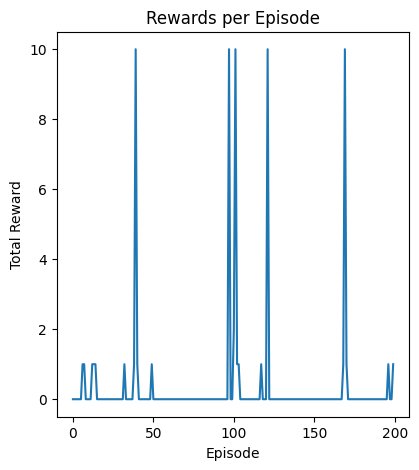

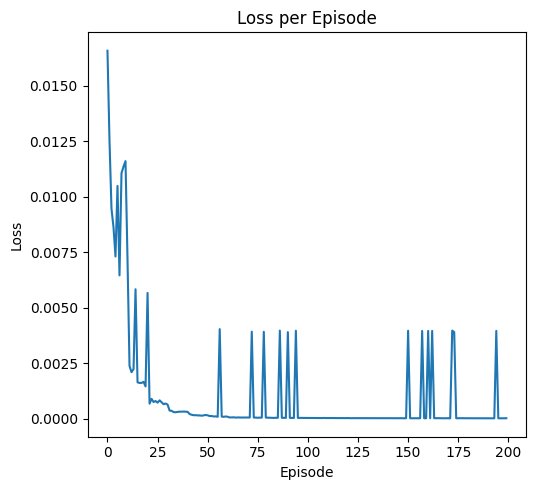

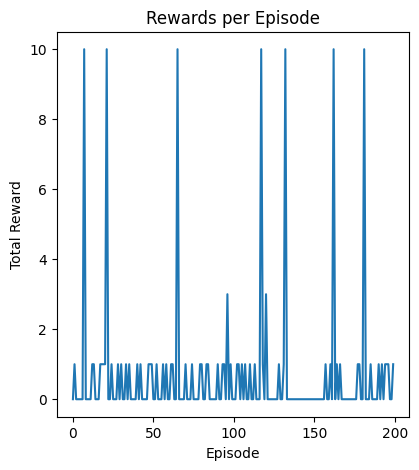

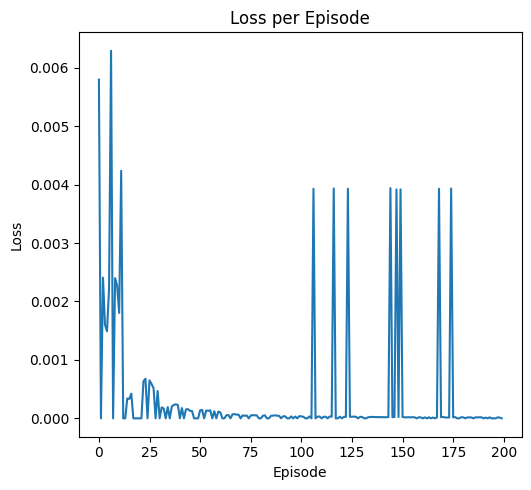

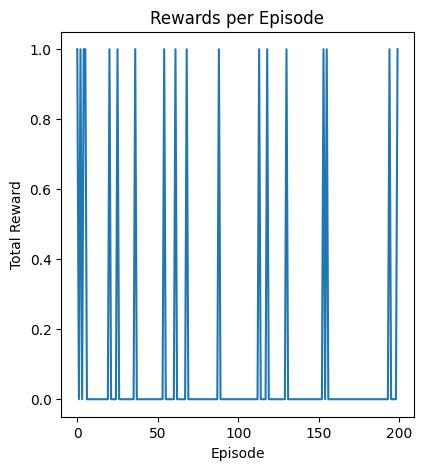

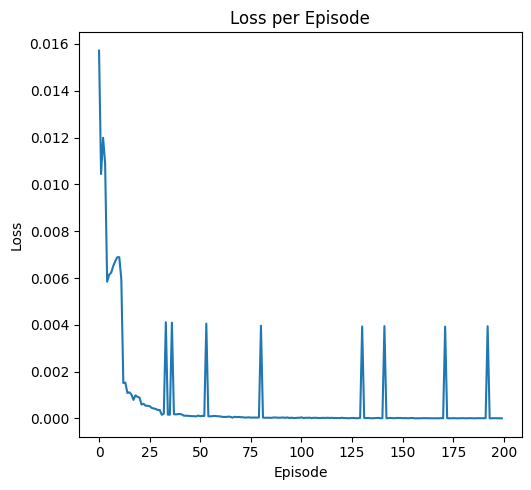

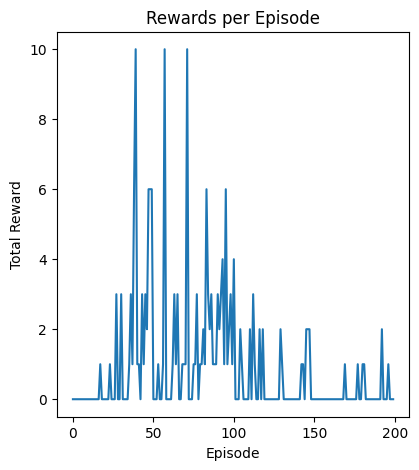

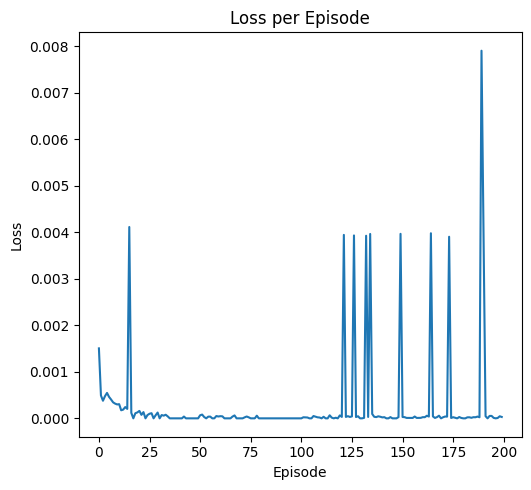

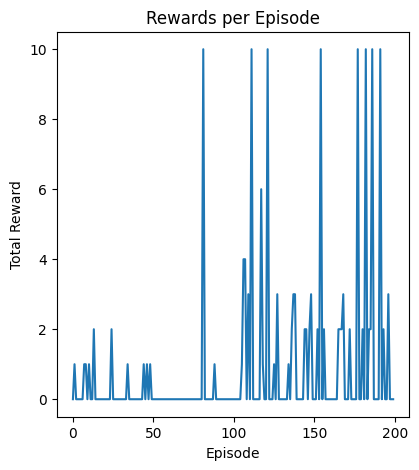

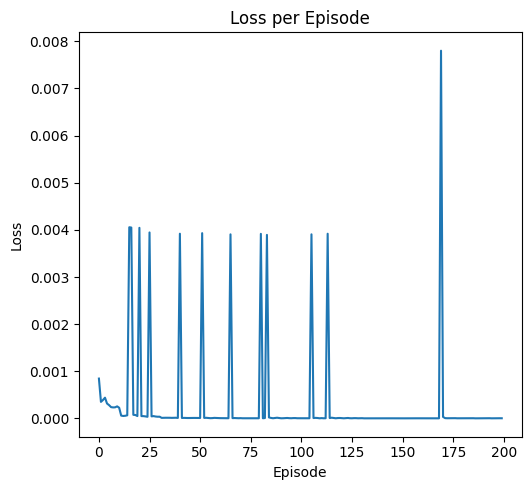

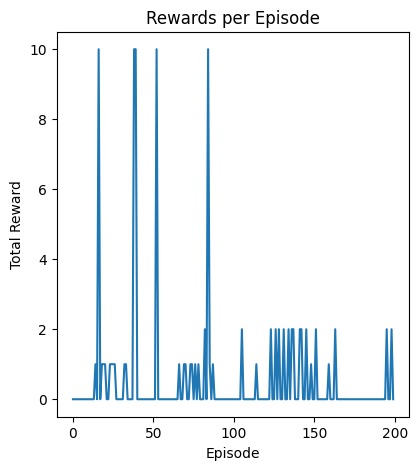

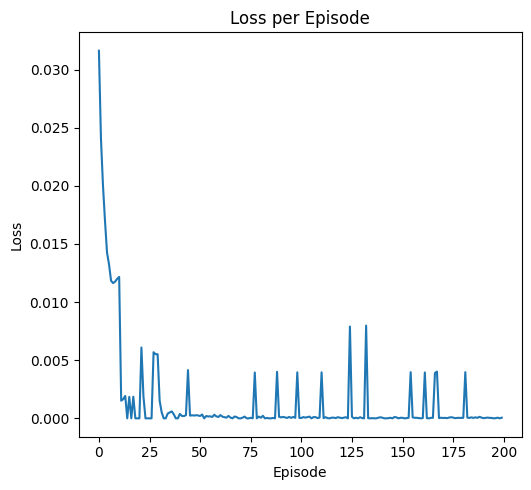

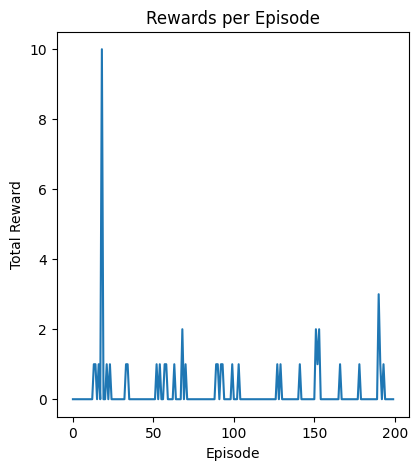

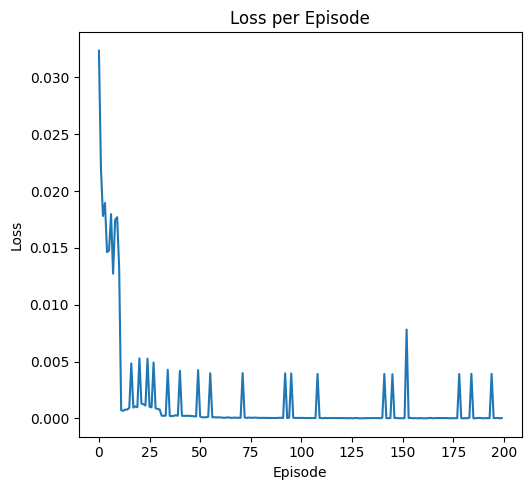

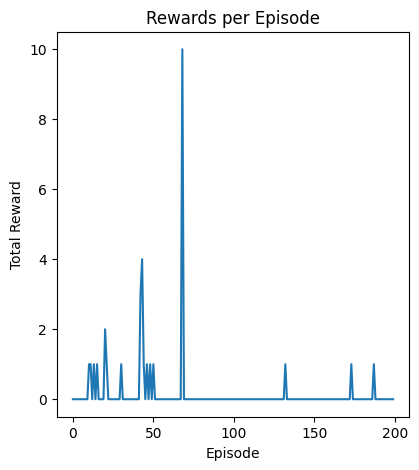

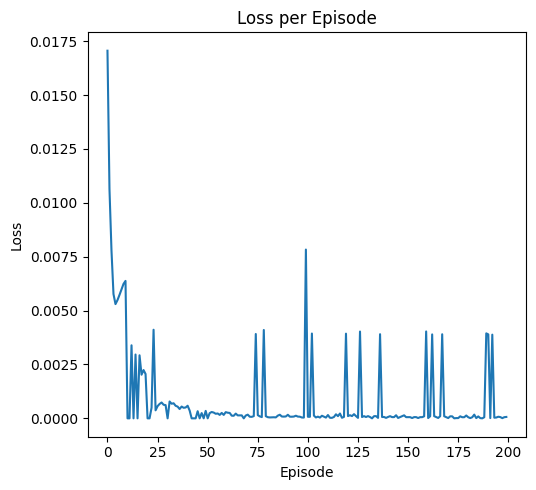

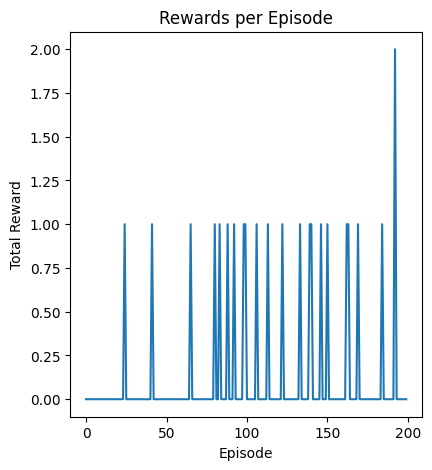

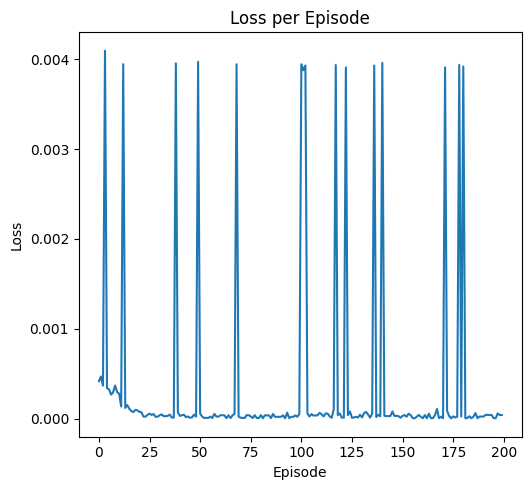

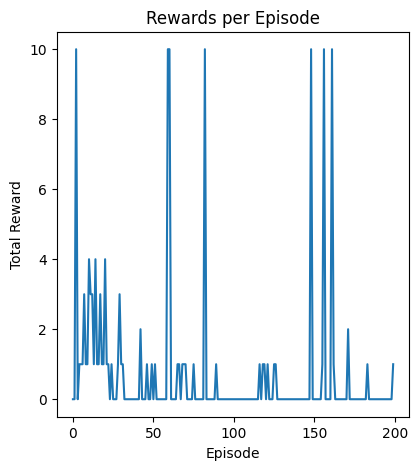

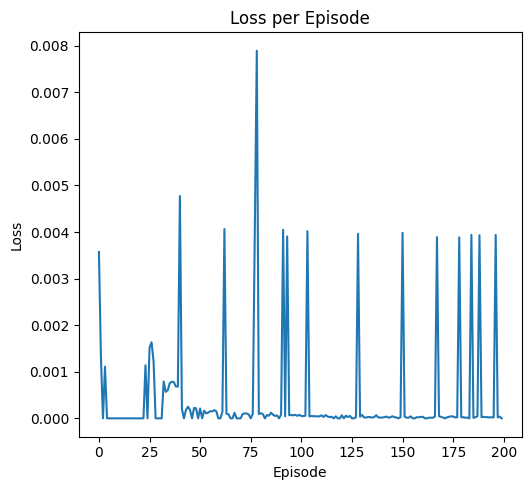

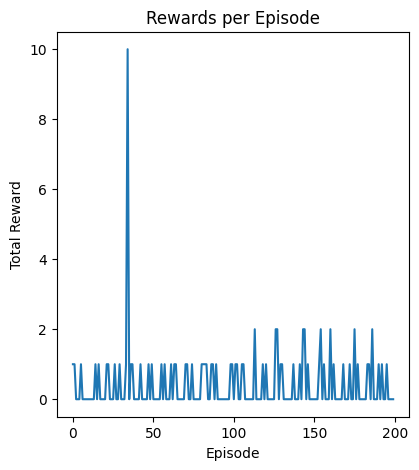

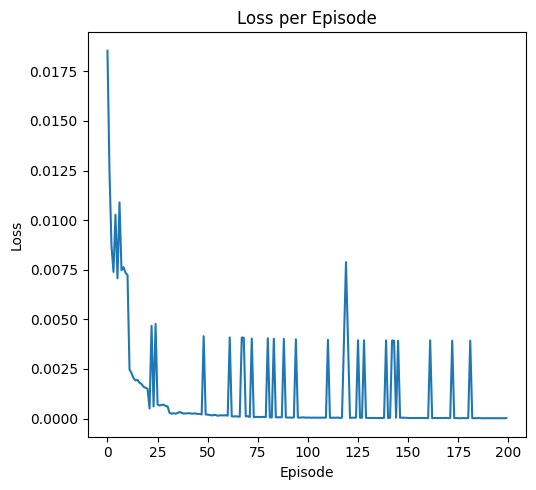

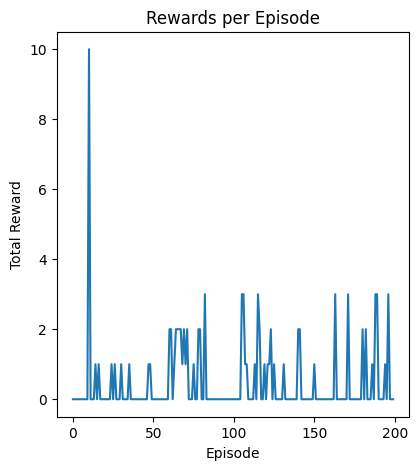

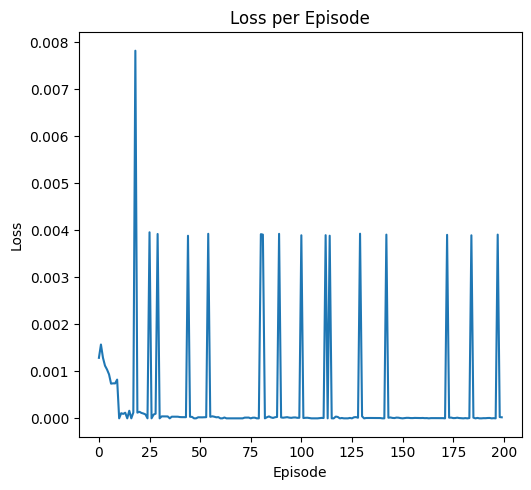

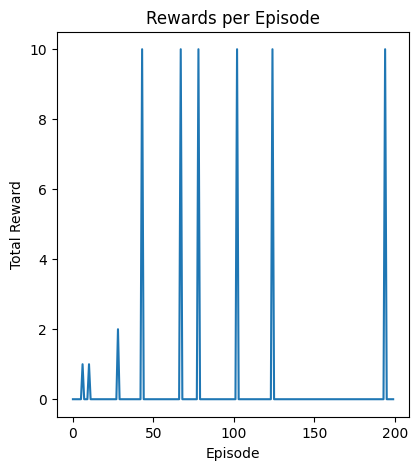

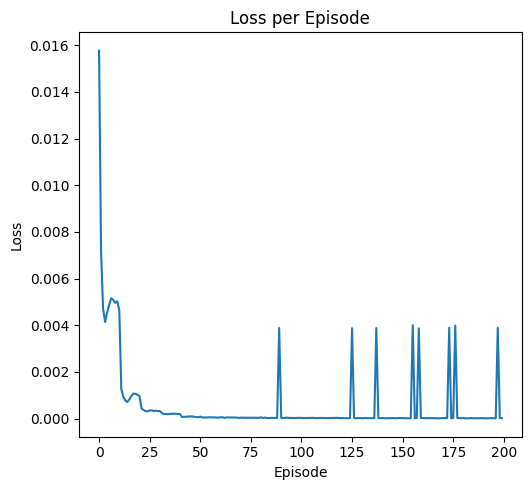

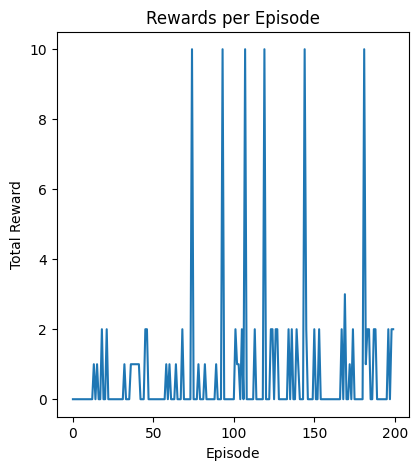

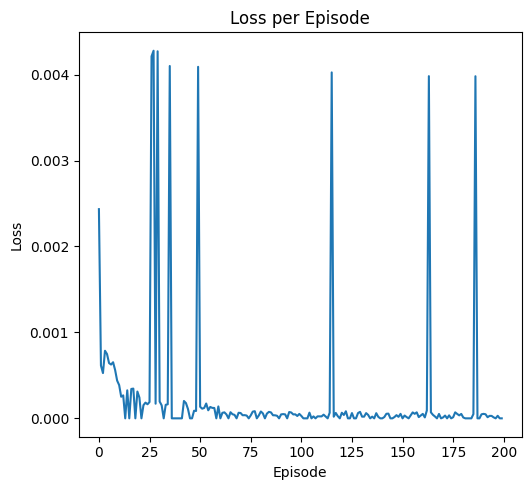

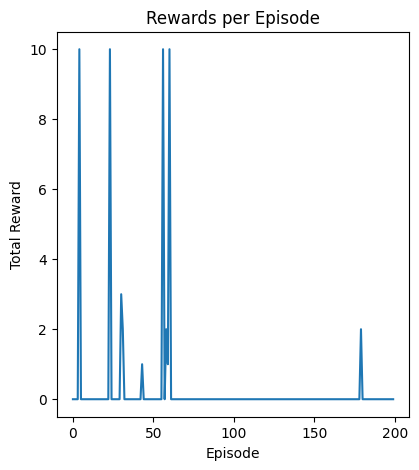

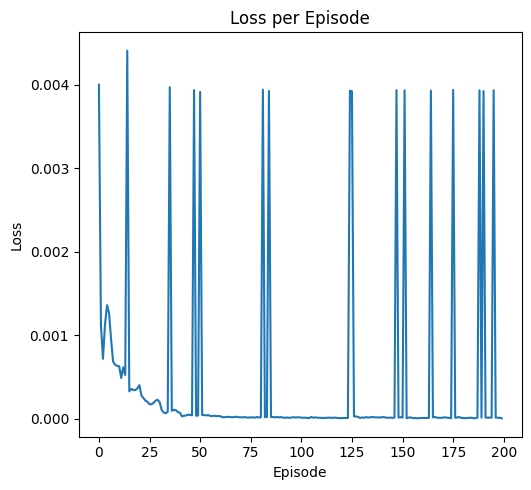

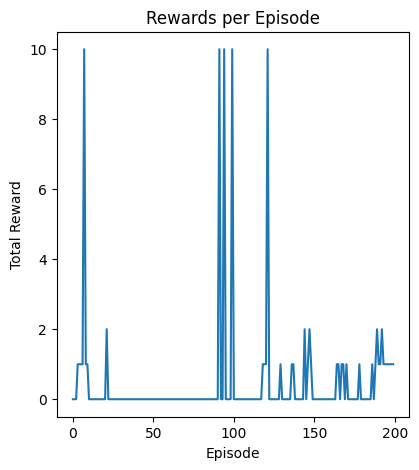

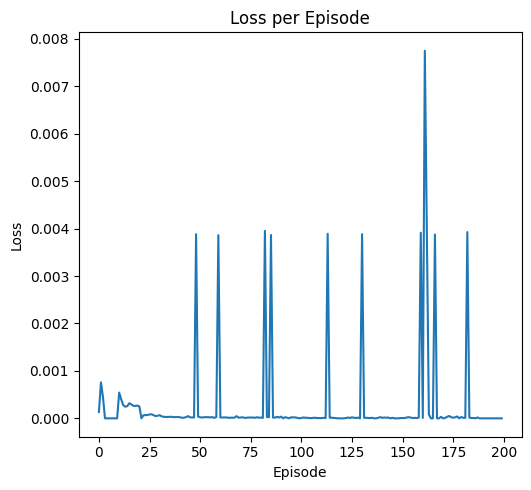

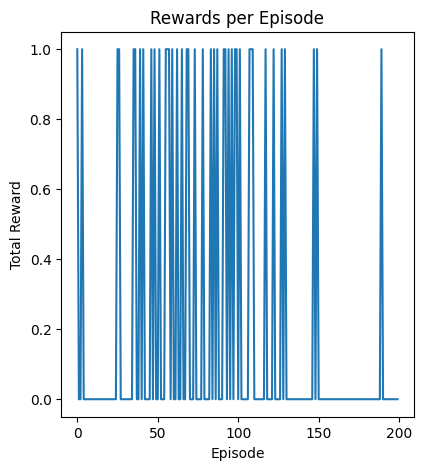

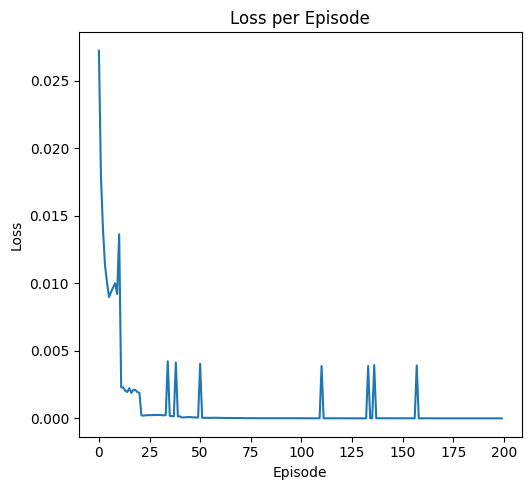

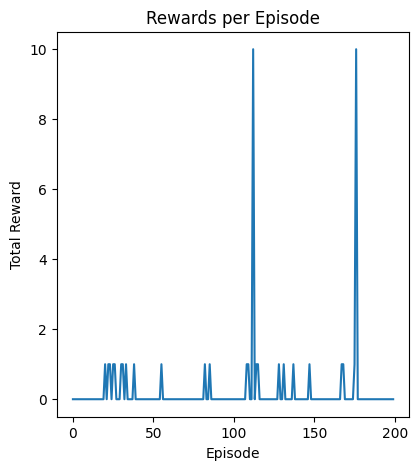

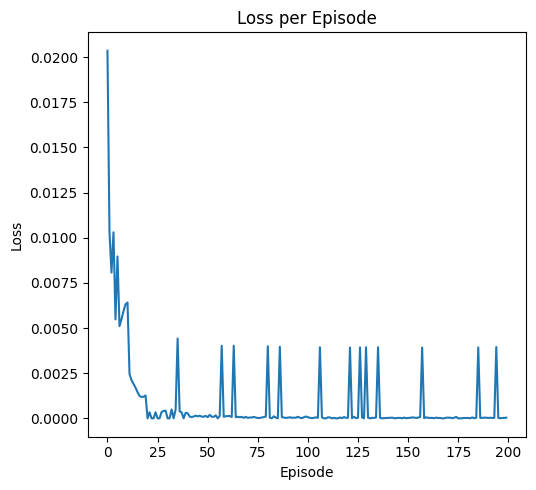

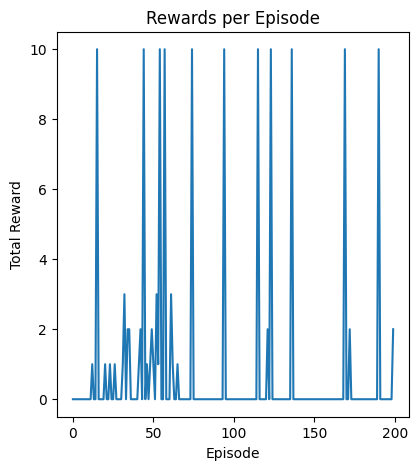

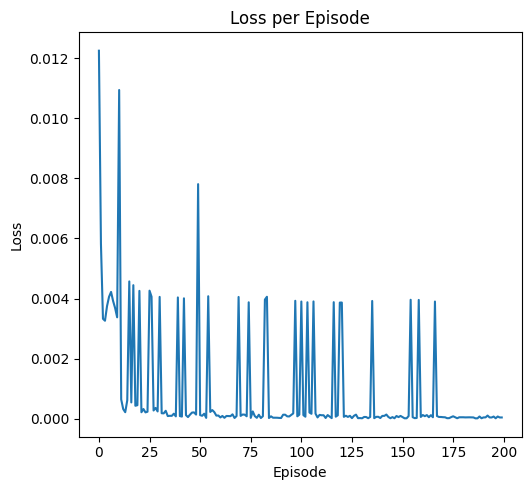

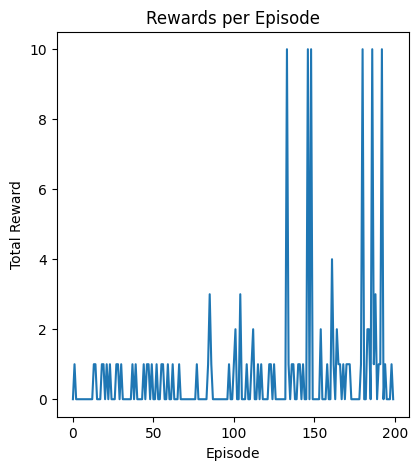

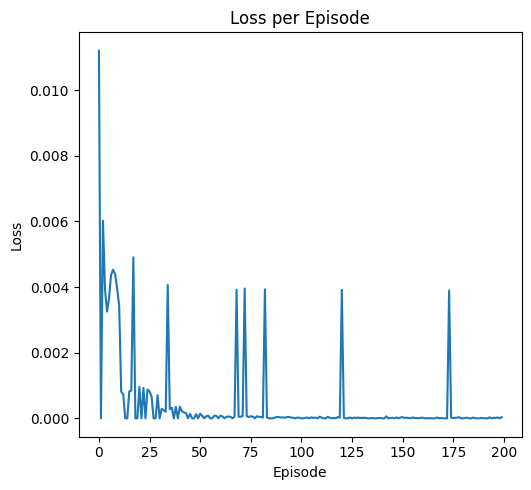

In [3]:



class PongEnvironment:
    def __init__(self, width=400, height=300):
        self.width = width
        self.height = height
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array([self.width // 2, random.randint(0,self.height) // 2], dtype=float)
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = random.randint(0,self.height)
        self.screen = pygame.display.set_mode((self.width, self.height))

    def reset(self):
        self.start_time=time.time()
        self.total_reward=0
        self.ball_pos = np.array([self.width // 2, random.randint(0,self.height)], dtype=float)
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = random.randint(0,self.height)
        return torch.FloatTensor(self.get_state())

    def step(self, action):
        if action == 0:  # Move up
            move = -5
        else:  # Move down
            move = 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel

        if self.ball_pos[1] <= self.ball_radius or self.ball_pos[1] >= self.height - self.ball_radius:
            self.ball_vel[1] *= -1

        reward = 0
        done = False

        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if self.paddle_pos - self.paddle_height / 2 <= self.ball_pos[1] <= self.paddle_pos + self.paddle_height / 2:
                self.ball_vel[0] *= -1
                reward = 1
                self.total_reward+=1
            else:
                reward = 0
                done = True
        if self.total_reward>10 or time.time()-self.start_time>10:
            done=True
        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return torch.FloatTensor(self.get_state()), reward, done  # Return state as a tensor

    def move_paddle(self, move):
        self.paddle_pos = np.clip(self.paddle_pos + move, self.paddle_height / 2, self.height - self.paddle_height / 2)

    def get_state(self):
        return np.array([
            self.ball_pos[0] / self.width,
            self.ball_pos[1] / self.height,
            self.ball_vel[0] / 100,
            self.ball_vel[1] / 100,
            self.paddle_pos / self.height
        ])

    def render(self):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(self.screen, (255, 255, 255), pygame.Rect(0, int(self.paddle_pos - self.paddle_height / 2), self.paddle_width, self.paddle_height))
        pygame.draw.circle(self.screen, (255, 255, 255), (int(self.ball_pos[0]), int(self.ball_pos[1])), self.ball_radius)
        pygame.display.flip()

class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.fc(x)


def train_dqn_2(env,env2,replay_buffer):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    ACTION_SPACE = [0, 1]

    state_size = env.get_state().shape[0]
    action_size = len(ACTION_SPACE)
    hidden_size = 64
    batch_size = 256
    policy_net = DQN(state_size, action_size, hidden_size)
    target_net = DQN(state_size, action_size, hidden_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []
    avg_hit=0
    for episode in range(200):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []
        avg_hit=sum(rewards_per_episode)/(len(rewards_per_episode)+1)

        if not episode%5:
                for expert_agent in expert_agents:
                    obs_t = env2.reset()
                    done_t=False
                    for _ in range(1000):  # Collect 1000 steps from each expert
                        action_t, __t = expert_agent.model.predict(obs_t)
                        new_obs_t, reward_t, done_t = env2.step(action_t)
                        state_transformed=np.array([np.array(obs_t.detach().numpy())][0]).reshape(1, -1)

                        next_state_transformed=np.array([np.array(new_obs_t.detach().numpy())][0]).reshape(1, -1)
                        # print(state_transformed)
                        # obs, action, reward, new_obs, float(done))
                        # print(state.shape())
                        replay_buffer.add(state_transformed, [action_t], [reward_t], next_state_transformed, float(done_t))

                        # replay_buffer.add(obs_t, action_t, reward_t, new_obs_t, float(done_t))
                        obs_t = new_obs_t
                        if done_t:
                            obs_t = env2.reset()
            # else:
            #     print('here')
            #     for _ in range(1000):  # Collect 1000 steps from each expert
            #             epsilon = max(epsilon_end, epsilon_decay * epsilon)
            #             if random.random() > epsilon:
            #                 with torch.no_grad():
            #                     state_t = state.unsqueeze(0)
            #                     action_values = policy_net(state_t)
            #                     action = ACTION_SPACE[action_values.max(1)[1].item()]
            #             else:
            #                 action = random.choice(ACTION_SPACE)

            #             next_state, reward, done = env.step(action)
            #             replay_buffer.add(next_state, [action], [reward], next_state, float(done))
                        

            #             state = next_state
            #             total_reward += reward
                
            

        while not done and total_reward<10:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = state.unsqueeze(0)
                    action_values = policy_net(state_t)
                    action = ACTION_SPACE[action_values.max(1)[1].item()]
            else:
                action = random.choice(ACTION_SPACE)

            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward
            # print(total_reward)

        if (len(replay_buffer.buffer) > batch_size  and total_reward==0):
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                # actions = actions.view(-1)
                # print("Actions shape: ", actions.shape)
                # print("Policy net output shape: ", policy_net(states).shape)
                # print("next_state_values shape: ", next_states.shape)
                # print("dones shape: ", dones.shape)
                # print("rewards shape: ", rewards.shape)

                actions = actions.view(-1, 1, 1)
                state_action_values = policy_net(states).gather(2, actions)
                dones = dones.unsqueeze(-1)


                # Perform gather operation
                # state_action_values = policy_net(states).gather(1, actions.unsqueeze(-1))
                # state_action_values = policy_net(states).gather(1, actions.view(-1, 1))
                next_state_values = target_net(next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * 0.99 * (1 - dones)) + rewards

                loss = criterion(state_action_values, expected_state_action_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())


    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('rewards_per_episode.png')

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('loss_per_episode.png')

    return rewards_per_episode, losses, policy_net



def train_dqn(env,env2,replay_buffer):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    ACTION_SPACE = [0, 1]

    state_size = env.get_state().shape[0]
    action_size = len(ACTION_SPACE)
    hidden_size = 64
    batch_size = 256
    policy_net = DQN(state_size, action_size, hidden_size)
    target_net = DQN(state_size, action_size, hidden_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []
    avg_hit=0
    for episode in range(200):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []
        avg_hit=sum(rewards_per_episode)/(len(rewards_per_episode)+1)

        if not episode%5:
                for expert_agent in expert_agents:
                    obs_t = env2.reset()
                    done_t=False
                    for _ in range(1000):  # Collect 1000 steps from each expert
                        action_t, __t = expert_agent.model.predict(obs_t)
                        new_obs_t, reward_t, done_t = env2.step(action_t)
                        state_transformed=np.array([np.array(obs_t.detach().numpy())][0]).reshape(1, -1)

                        next_state_transformed=np.array([np.array(new_obs_t.detach().numpy())][0]).reshape(1, -1)
                        # print(state_transformed)
                        # obs, action, reward, new_obs, float(done))
                        # print(state.shape())
                        replay_buffer.add(state_transformed, [action_t], [reward_t], next_state_transformed, float(done_t))

                        # replay_buffer.add(obs_t, action_t, reward_t, new_obs_t, float(done_t))
                        obs_t = new_obs_t
                        if done_t:
                            obs_t = env2.reset()
            # else:
            #     print('here')
            #     for _ in range(1000):  # Collect 1000 steps from each expert
            #             epsilon = max(epsilon_end, epsilon_decay * epsilon)
            #             if random.random() > epsilon:
            #                 with torch.no_grad():
            #                     state_t = state.unsqueeze(0)
            #                     action_values = policy_net(state_t)
            #                     action = ACTION_SPACE[action_values.max(1)[1].item()]
            #             else:
            #                 action = random.choice(ACTION_SPACE)

            #             next_state, reward, done = env.step(action)
            #             replay_buffer.add(next_state, [action], [reward], next_state, float(done))
                        

            #             state = next_state
            #             total_reward += reward
                
            

        while not done and total_reward<10:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = state.unsqueeze(0)
                    action_values = policy_net(state_t)
                    action = ACTION_SPACE[action_values.max(1)[1].item()]
            else:
                action = random.choice(ACTION_SPACE)

            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward
            # print(total_reward)

        if (len(replay_buffer.buffer) > batch_size  ):
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                # actions = actions.view(-1)
                # print("Actions shape: ", actions.shape)
                # print("Policy net output shape: ", policy_net(states).shape)
                # print("next_state_values shape: ", next_states.shape)
                # print("dones shape: ", dones.shape)
                # print("rewards shape: ", rewards.shape)

                actions = actions.view(-1, 1, 1)
                state_action_values = policy_net(states).gather(2, actions)
                dones = dones.unsqueeze(-1)


                # Perform gather operation
                # state_action_values = policy_net(states).gather(1, actions.unsqueeze(-1))
                # state_action_values = policy_net(states).gather(1, actions.view(-1, 1))
                next_state_values = target_net(next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * 0.99 * (1 - dones)) + rewards

                loss = criterion(state_action_values, expected_state_action_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())


    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('rewards_per_episode.png')

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('loss_per_episode.png')

    return rewards_per_episode, losses, policy_net



alls=[[],[]]
for _ in range(10):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    env = PongEnvironment()
    env2 = PongEnvironment()
    print(env)
    rewards, losses, trained_net = train_dqn(env,env2,replay_buffer)
    alls[0].append(rewards)
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    env = PongEnvironment()
    env2 = PongEnvironment()
    print(env)
    rewards, losses, trained_net = train_dqn_2(env,env2,replay_buffer)
    alls[1].append(rewards)
    


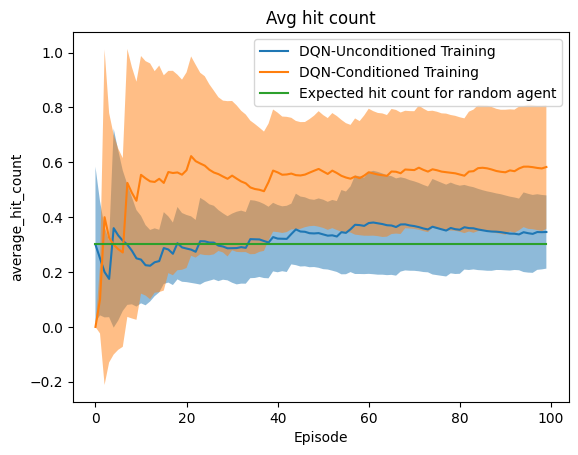

In [6]:
alls_3=[]
for alls_1 in alls[0]:
    t=0
    list_1=[]
    for i in range(100):
        t+=alls_1[i]
        list_1.append(t/(i+1))
    alls_3.append(list_1)
    rewards=alls_3
mean_regret = np.mean(rewards, axis=0)
std_regret = np.std(rewards, axis=0)

upper_bound = mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))
lower_bound = mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))

fig, ax = plt.subplots()
ax.plot(mean_regret, label="DQN-Unconditioned Training")
ax.fill_between(np.arange(len(mean_regret)), lower_bound ,upper_bound , alpha=0.5)

alls_3=[]
for alls_1 in alls[1]:
    t=0
    list_1=[]
    for i in range(100):
        t+=alls_1[i]
        list_1.append(t/(i+1))
    alls_3.append(list_1)
    rewards=alls_3
mean_regret = np.mean(rewards, axis=0)
std_regret = np.std(rewards, axis=0)

upper_bound = mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))
lower_bound = mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))

ax.plot(mean_regret, label="DQN-Conditioned Training")
ax.fill_between(np.arange(len(mean_regret)), lower_bound ,upper_bound , alpha=0.5)


ax.set_title(f"Avg hit count")
ax.set_xlabel("Episode")
ax.set_ylabel("average_hit_count")
ax.plot([0.304 for i in range(100)],label='Expected hit count for random agent')

plt.legend()
plt.show()
